In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import glob
import os
import unicodedata
import string
import random
import numpy as np
import matplotlib.pyplot as plt

# 定义一个函数，用于查找与指定路径模式匹配的文件
def findFiles(path): 
    return glob.glob(path)

# 定义所有可能字符
all_letters = string.ascii_letters + " .,;'"
# 计算字符总数
n_letters = len(all_letters)

# 函数将Unicode字符串转换为ASCII
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# 初始化一个字典，用于保存每个类别的行
category_lines = {}
# 初始化一个列表，用于保存所有类别的名称
all_categories = []

# 从文件中读取行并将其规范化为ASCII
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

# 遍历每个与指定模式匹配的文件
for filename in findFiles('data/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

# 根据all_letters中字母的顺序找到字母的索引，例如："a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)
# 仅用于演示，将字母转换为<1 x n_letters>的张量
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# 将一行转换为<line_length x 1 x n_letters>的张量，
# 或者是一个由单热编码字母向量组成的数组
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i
# 创建自定义数据集类
class NamesDataset(Dataset):
    def __init__(self, category_lines, all_categories, all_letters):
        self.category_lines = category_lines
        self.all_categories = all_categories
        self.all_letters = all_letters
        self.n_categories = len(all_categories)

        self.data = []
        for category in all_categories:
            for line in category_lines[category]:
                category_idx = all_categories.index(category)
                line_tensor = self.lineToTensor(line)
                self.data.append((category_idx, line_tensor))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        category_idx, line_tensor = self.data[idx]
        return category_idx, line_tensor

    def letterToIndex(self, letter):
        return self.all_letters.find(letter)

    def lineToTensor(self, line):
        tensor = torch.zeros(len(line), len(self.all_letters))
        for li, letter in enumerate(line):
            tensor[li][self.letterToIndex(letter)] = 1
        return tensor

# 初始化数据集
dataset = NamesDataset(category_lines, all_categories, all_letters)

# 将数据集拆分为训练集和测试集
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
def collate_fn(batch):
    # 获取类别张量和行张量
    category_tensors, line_tensors = zip(*batch)
    
    # 将类别转换为张量
    category_tensors = torch.tensor(category_tensors, dtype=torch.long)
    
    # 获取每个序列的长度
    lengths = [tensor.size(0) for tensor in line_tensors]
    max_length = max(lengths)
    
    # 创建填充后的张量
    padded_tensors = torch.zeros(len(line_tensors), max_length, n_letters)
    for i, tensor in enumerate(line_tensors):
        end = lengths[i]
        padded_tensors[i, :end, :] = tensor
    
    return category_tensors, padded_tensors


# 创建DataLoader
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)





In [2]:


class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)
n_categories = len(all_categories)
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)
print(rnn)
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
rnn.to(device)


RNN(
  (i2h): Linear(in_features=185, out_features=128, bias=True)
  (i2o): Linear(in_features=185, out_features=18, bias=True)
  (softmax): LogSoftmax(dim=1)
)


RNN(
  (i2h): Linear(in_features=185, out_features=128, bias=True)
  (i2o): Linear(in_features=185, out_features=18, bias=True)
  (softmax): LogSoftmax(dim=1)
)

In [3]:
criterion = nn.NLLLoss()
optimizer = optim.SGD(rnn.parameters(), lr=0.005)
def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()
    rnn.zero_grad()
    # 注意 line_tensor 的维度应该是 [batch_size, seq_len, input_size]
    # 我们需要将其转换为 [seq_len, batch_size, input_size] 以符合 RNN 的输入
    line_tensor = line_tensor.permute(1, 0, 2)
    for i in range(line_tensor.size(0)):
        output, hidden = rnn(line_tensor[i], hidden)
    loss = criterion(output, category_tensor)
    loss.backward()
    optimizer.step()
    return output, loss.item()


def evaluate(line_tensor):
   
    hidden = rnn.initHidden()
    line_tensor = line_tensor.permute(1, 0, 2)
    
    for i in range(line_tensor.size(0)):
        output, hidden = rnn(line_tensor[i], hidden)
    
    return output


In [4]:
# 定义训练和评估的主循环
def train_and_evaluate(num_epochs):
    train_losses = []
    test_accuracies = []
    
    
    for epoch in range(num_epochs):
        total_loss = 0
        for category_tensor, line_tensor in train_loader:
            category_tensor = category_tensor.to(torch.long)
            output, loss = train(category_tensor, line_tensor)
            total_loss += loss
        
        train_losses.append(total_loss / len(train_loader))
        
        correct = 0
        total = 0
        with torch.no_grad():
            for category_tensor, line_tensor in test_loader:
                output = evaluate(line_tensor)
                _, predicted = torch.max(output, 1)
                total += category_tensor.size(0)
                correct += (predicted == category_tensor).sum().item()
                
               
        
        test_accuracies.append(correct / total)
        
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss / len(train_loader):.4f}, Accuracy: {correct / total:.4f}')
    
    return train_losses, test_accuracies

Epoch 1/10, Loss: 1.4263, Accuracy: 0.6697
Epoch 2/10, Loss: 1.1097, Accuracy: 0.7009
Epoch 3/10, Loss: 1.0096, Accuracy: 0.7126
Epoch 4/10, Loss: 0.9477, Accuracy: 0.7268
Epoch 5/10, Loss: 0.9151, Accuracy: 0.7333
Epoch 6/10, Loss: 0.8767, Accuracy: 0.7328
Epoch 7/10, Loss: 0.8558, Accuracy: 0.7308
Epoch 8/10, Loss: 0.8449, Accuracy: 0.7305
Epoch 9/10, Loss: 0.8275, Accuracy: 0.7333
Epoch 10/10, Loss: 0.8177, Accuracy: 0.7372


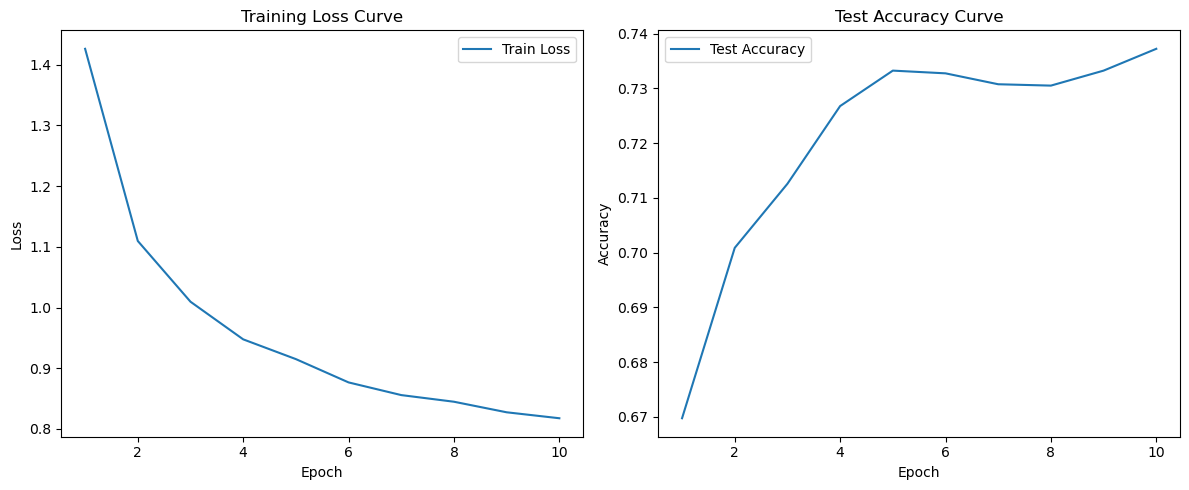

In [5]:
# 开始训练并绘制曲线
num_epochs = 10
train_losses, test_accuracies = train_and_evaluate(num_epochs)

# 绘制训练损失曲线和验证准确度曲线
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Test Accuracy Curve')
plt.legend()

plt.tight_layout()
plt.show()



C:\Users\苏集源\AppData\Local\Temp\ipykernel_1584\3714670648.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + all_categories, rotation=90)
C:\Users\苏集源\AppData\Local\Temp\ipykernel_1584\3714670648.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + all_categories)


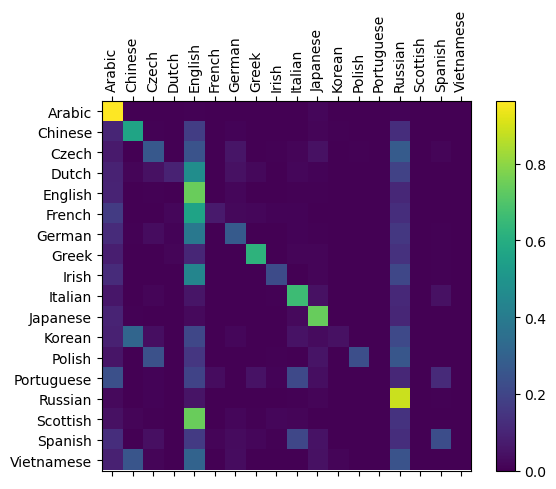

In [23]:
import random
import matplotlib.ticker as ticker

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor
import matplotlib.ticker as ticker
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line

def evaluate(line_tensor):
    hidden = rnn.initHidden()
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()